In [1]:
using Revise

In [2]:
using PyCall, PyPlot, Statistics, JuMP
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1278
┌ Info: Precompiling ClimateMARGO [d3f62095-a717-45bf-aadc-ac9dfc258fa6]
└ @ Base loading.jl:1278


In [3]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting
using ClimateMARGO.PolicyResponse

In [4]:
include("suboptimal_policy.jl");

# A policy process for responding to suboptimal climate outcomes

In [5]:
append_model!(model_list, model) = append!(model_list, [deepcopy(model)]);

In [6]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

base_model.economics.ρ = 0.02
base_model.economics.mitigate_init = 0.
delay_deployment=Dict(
    "mitigate"=>0,
    "remove"=>0,
    "geoeng"=>0,
    "adapt"=>0
);

max_update = Dict("mitigate"=>nothing, "remove"=>nothing, "geoeng"=>1., "adapt"=>0.1);
max_slope = Dict("mitigate"=>1. /40., "remove"=>1. /40., "geoeng"=>1. /100., "adapt"=>0.);
max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.);

## 1. Under-ambitious case

In [7]:
model = deepcopy(base_model)

temp_goal_list = [];
model_list = [];
hypo_model_list = [];

optimal = deepcopy(model)
optimize_controls!(optimal, delay_deployment=delay_deployment, max_slope=max_slope, max_deployment=max_deployment);

append_model!(model_list, model);
append_model!(hypo_model_list, model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded


In [8]:
Δt = 10.
suboptimality = -0.75

for i in 1:10
    println("Evaluating policy in ", model.domain.present_year)
    temp_goal = 2.0
    m = optimize_controls!(model, temp_goal = temp_goal, delay_deployment=delay_deployment, max_slope=max_slope, max_deployment=max_deployment);
    while raw_status(m) != "Solve_Succeeded"
        temp_goal += 0.0025
        m = optimize_controls!(model, temp_goal = temp_goal, delay_deployment=delay_deployment, max_slope=max_slope, max_deployment=max_deployment, print_raw_status=false);
    end
    if temp_goal >= 2.0
        print("Increased temperature goal to ", round(temp_goal, digits=3), "\n")
    end
    append_model!(hypo_model_list, model);
    suboptimal_step_forward!(model, model_list[end], Δt, 1+suboptimality);
    append_model!(model_list, model);
    append!(temp_goal_list, temp_goal);
end

Evaluating policy in 2020.0
Solve_Succeeded
Increased temperature goal to 2.0
Evaluating policy in 2030.0
Solve_Succeeded
Increased temperature goal to 2.0
Evaluating policy in 2040.0
Solve_Succeeded
Increased temperature goal to 2.0
Evaluating policy in 2050.0
Infeasible_Problem_Detected
Increased temperature goal to 2.08
Evaluating policy in 2060.0
Infeasible_Problem_Detected
Increased temperature goal to 2.205
Evaluating policy in 2070.0
Infeasible_Problem_Detected
Increased temperature goal to 2.27
Evaluating policy in 2080.0
Infeasible_Problem_Detected
Increased temperature goal to 2.327
Evaluating policy in 2090.0
Infeasible_Problem_Detected
Increased temperature goal to 2.38
Evaluating policy in 2100.0
Infeasible_Problem_Detected
Increased temperature goal to 2.43
Evaluating policy in 2110.0
Infeasible_Problem_Detected
Increased temperature goal to 2.462


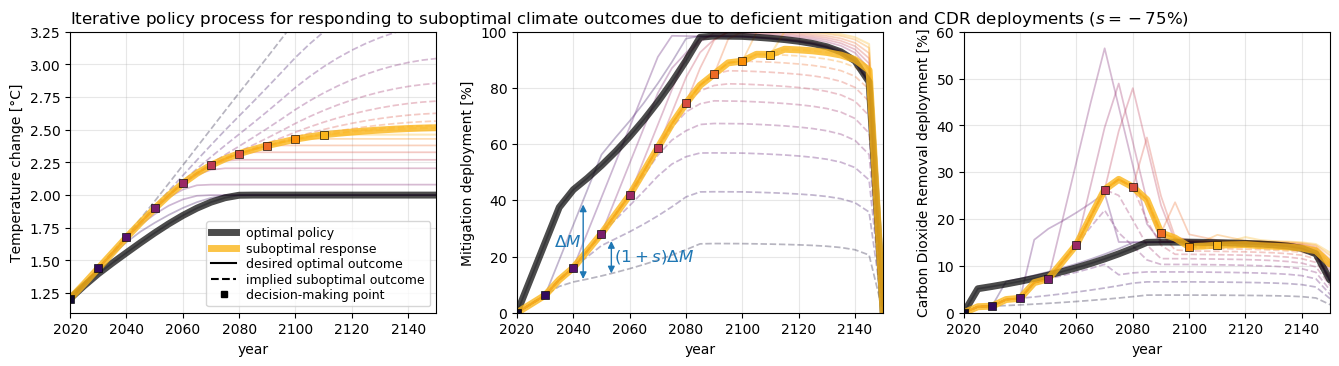

In [9]:
N = length(model_list)

xt = 2020:20:2150
xtn = convert(Array{Any}, copy(xt))
xtn[((xtn.-2000).%40).==0] .= nothing

arrowprops=Dict(
    "arrowstyle"=>"<|-|>",
    "fc"=>"C0", "ec"=>"C0"
)

alpha_step = 0.3
alpha_thick = 0.7
lw_thick = 5
cmap = get_cmap("inferno");

figure(figsize=(13.5,3.6))

ax = subplot(1,3,1)
grid(true, alpha=0.3)
for (i, m) in enumerate(model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), T(m, M=true, R=true, G=true, A=true), "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end

for (i, m) in enumerate(hypo_model_list[2:end])
    if i==length(hypo_model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), T(m, M=true, R=true, G=true, A=true), "-", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
plot(t(optimal), T(optimal, M=true, R=true, G=true, A=true), "k", lw=lw_thick, alpha=alpha_thick, label="optimal policy")
m = model_list[end]
plot(t(m), T(m, M=true, R=true, G=true, A=true), lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)), label="suboptimal response")
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], T(m, M=true, R=true, G=true, A=true)[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
ylim([optimal.physics.T0, 3.25])
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
plot([],[], "k-", label="desired optimal outcome")
plot([],[], "k--", label="implied suboptimal outcome")
plot([],[], "ks", label="decision-making point", markersize=5)
legend(loc="lower right", labelspacing = 0.2, fontsize=9);
ylabel("Temperature change [°C]")

subplot(1,3,2)
grid(true, alpha=0.3)
for (i, m) in enumerate(model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.mitigate, "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
for (i, m) in enumerate(hypo_model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.mitigate, "-", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
plot(t(optimal), optimal.controls.mitigate, "k-", lw=lw_thick, alpha=alpha_thick)
m = model_list[end]
plot(t(m), m.controls.mitigate, lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)))
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], m.controls.mitigate[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
yt = 0.:0.2:1.
yticks(yt, Int.(yt*100))
ylim(0, 1)
ylabel("Mitigation deployment [%]")

annotate("", (2043.5, 0.11), xytext=(2043.5, 0.395), arrowprops=arrowprops)
annotate(L"$\Delta M$", (2033, 0.235), fontsize=12, color="C0");

annotate("", (2053.5, 0.13), xytext=(2053.5, 0.265), arrowprops=arrowprops)
annotate(L"$(1+s)\Delta M$", (2054.5, 0.185), fontsize=12, color="C0");

subplot(1,3,3)
grid(true, alpha=0.3)
for (i, m) in enumerate(model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.remove, "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
for (i, m) in enumerate(hypo_model_list[2:end])
    if i==length(model_list[2:end]); lw=1.5; else; lw=1.25; end
    plot(t(m), m.controls.remove, "-", color=cmap(i/(N+1)), lw=lw, alpha=alpha_step)
end
plot(t(optimal), optimal.controls.remove, "k-", lw=lw_thick, alpha=alpha_thick)
m = model_list[end]
plot(t(m), m.controls.remove, lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)))
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], m.controls.remove[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
yt = 0.:0.1:0.6
yticks(yt, Int.(yt*100))
ylim(0, 0.6)
ylabel("Carbon Dioxide Removal deployment [%]")
xticks()
tight_layout(w_pad=1.8)

suboptimal_percentage = abs(Int(round(suboptimality*100)))
ax.set_title(
    string(L"Iterative policy process for responding to suboptimal climate outcomes due to deficient mitigation and CDR deployments ($s=-$","$(suboptimal_percentage)%)"),
    loc="left", y=1.045
)

savefig("figures/suboptimal_under-ambitious.png", dpi=200., bbox_inches="tight")